# Bayesian Analysis of NFL 4th Downs

This notebook performs an analysis on NFL 4th down conversions. First, we do exploratory analysis on 4th downs. Then we implement Bayesian Logistic regression to analyze what drives conversions.

For the full analysis and supporting material, please look here:
https://even-humidity-112.notion.site/NFL-4th-Down-Analysis-ca2a3ee6942f4e0788c605ecf10547d2


## Import Packages

In [2]:
# Mount gdrive

from google.colab import drive 
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [1]:
!pip install bambi

In [3]:
# Import libraries
# Scipy
from scipy import stats
from scipy.stats import gamma

# Bambi for model building
import bambi as bmb

# Arviz
import arviz as az

# Numpy
import numpy as np
import pandas as pd

# UUID package
import uuid

# Plot packages
from matplotlib.ticker import PercentFormatter
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

from google.colab import files

# Bayesian and Math 
import pymc3 as pm
import arviz as az
import random
import math
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split

# Misc
import xarray as xr
import warnings

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Data

In [4]:
# Read 5 years of play-by-play NFL data.

df_2017=pd.read_csv('gdrive/MyDrive/nfl_datasets/pbp-2017.csv')
df_2018=pd.read_csv('gdrive/MyDrive/nfl_datasets/pbp-2018.csv')
df_2019=pd.read_csv('gdrive/MyDrive/nfl_datasets/pbp-2019.csv')
df_2020=pd.read_csv('gdrive/MyDrive/nfl_datasets/pbp-2020.csv')
df_2021=pd.read_csv('gdrive/MyDrive/nfl_datasets/pbp-2021.csv')

In [5]:
# Drop null columns.

for df in [df_2017, df_2018, df_2019, df_2020, df_2021]:
  df.dropna(how='all', axis=1, inplace=True)

In [6]:
# Create a dataset with all seasons.

df = pd.concat([df_2017, df_2018, df_2019, df_2020, df_2021])

In [7]:
df['PlayId'] = [uuid.uuid4() for _ in range(len(df.index))]


# Exploratory Data Analysis 

In [8]:
df.head(2)

,GameId,GameDate,Quarter,Minute,Second,OffenseTeam,DefenseTeam,Down,ToGo,YardLine,SeriesFirstDown,NextScore,Description,TeamWin,SeasonYear,Yards,Formation,PlayType,IsRush,IsPass,IsIncomplete,IsTouchdown,PassType,IsSack,IsChallenge,IsChallengeReversed,IsMeasurement,IsInterception,IsFumble,IsPenalty,IsTwoPointConversion,IsTwoPointConversionSuccessful,RushDirection,YardLineFixed,YardLineDirection,IsPenaltyAccepted,PenaltyTeam,IsNoPlay,PenaltyType,PenaltyYards,PlayId
0,2017123113,2017-12-31,4,7,9,LAC,LV,4,1,93,0,0,(7:09) 28-M.GORDON UP THE MIDDLE TO OAK 7 FOR ...,0,2017,0,UNDER CENTER,RUSH,1,0,0,0,NaN,0,0,0,0,0,0,0,0,0,CENTER,7,OPP,0,NaN,0,NaN,0,c7f6fe40-2a23-467f-9bf5-b0506261ea23
1,2017123113,2017-12-31,4,7,53,LAC,LV,3,1,93,0,0,(7:53) (NO HUDDLE) 28-M.GORDON RIGHT GUARD TO ...,0,2017,0,NO HUDDLE,RUSH,1,0,0,0,NaN,0,0,0,0,0,0,0,0,0,RIGHT GUARD,7,OPP,0,NaN,0,NaN,0,e2c564a9-5eef-4c2d-9a08-1ddfc16bb6ca


In [9]:
#Explore if IsTouchdown implies SeriesFirstDown

df[df["IsTouchdown"] == True].head(2)

,GameId,GameDate,Quarter,Minute,Second,OffenseTeam,DefenseTeam,Down,ToGo,YardLine,SeriesFirstDown,NextScore,Description,TeamWin,SeasonYear,Yards,Formation,PlayType,IsRush,IsPass,IsIncomplete,IsTouchdown,PassType,IsSack,IsChallenge,IsChallengeReversed,IsMeasurement,IsInterception,IsFumble,IsPenalty,IsTwoPointConversion,IsTwoPointConversionSuccessful,RushDirection,YardLineFixed,YardLineDirection,IsPenaltyAccepted,PenaltyTeam,IsNoPlay,PenaltyType,PenaltyYards,PlayId
18,2017123113,2017-12-31,2,0,30,LAC,LV,1,6,94,1,0,(:30) (SHOTGUN) 17-P.RIVERS PASS SHORT RIGHT T...,0,2017,6,SHOTGUN,PASS,0,1,0,1,SHORT RIGHT,0,0,0,0,0,0,0,0,0,NaN,6,OPP,0,NaN,0,NaN,0,932bd911-5906-47d7-886b-cb801a0e53fd
34,2017123113,2017-12-31,2,13,19,LAC,LV,1,10,60,1,0,(13:19) 28-M.GORDON RIGHT END TO OAK 29 FOR 11...,0,2017,11,UNDER CENTER,RUSH,1,0,0,1,NaN,0,0,0,0,0,1,0,0,0,RIGHT END,40,OPP,0,NaN,0,NaN,0,a63691bd-7e8f-4829-8506-0b3076c45623


In [10]:
# Number of games played in each Season.

df.groupby("SeasonYear").agg({"GameId": lambda x: x.nunique()})

,GameId
SeasonYear,
2017,255
2018,254
2019,237
2020,256
2021,164


In [11]:
# Define function to extract a simplified Play Type.

def f(row):
  if row["IsPass"] == 1 or row["IsSack"] == 1 or row["PlayType"] == "SCRAMBLE":
    val = "Pass"
  elif row["IsRush"] == 1:
    val = "Rush"
  elif row["PlayType"] == "FIELD GOAL":
    val = "Field Goal"
  elif row["PlayType"] == "PUNT":
    val = "Punt"
  else:
    val = "Other"
  return val

In [12]:
df['PlayTypeSimple'] = df.apply(f, axis=1)

In [13]:
# Ensure mapping is correct for Scramble.
df[df["PlayType"] == "SCRAMBLE"][["PlayTypeSimple", "IsRush", "IsPass", "PlayType"]].head()

,PlayTypeSimple,IsRush,IsPass,PlayType
75,Pass,1,0,SCRAMBLE
84,Pass,1,0,SCRAMBLE
128,Pass,1,0,SCRAMBLE
212,Pass,1,0,SCRAMBLE
349,Pass,1,0,SCRAMBLE


In [14]:
# Distribution of 4th Down Play Types by Season Year.

df_4th = df.query("Down == 4").groupby(["SeasonYear", "PlayTypeSimple"]).size()

df_4th_group = df.query("Down == 4").groupby(["SeasonYear"]).size()

df_4th.div(df_4th_group, level='SeasonYear').unstack("PlayTypeSimple")

PlayTypeSimple,Field Goal,Other,Pass,Punt,Rush
SeasonYear,,,,,
2017,0.236660,0.016057,0.081275,0.628458,0.037549
2018,0.229012,0.017003,0.101222,0.609458,0.043305
2019,0.233018,0.020045,0.113864,0.589087,0.043987
2020,0.240110,0.026099,0.121978,0.548077,0.063736
2021,0.233389,0.025332,0.131229,0.549003,0.061047


In [15]:
# Average yards to go on 4th down by Play.

df.query("Down == 4").groupby("PlayTypeSimple").agg({"ToGo":"mean"})

,ToGo
PlayTypeSimple,
Field Goal,7.508918
Other,4.644258
Pass,5.733901
Punt,9.029793
Rush,1.288732


In [16]:
# Pass Conversion vs Rush Conversion rates.

df.query("Down == 4 & (PlayTypeSimple == 'Pass' | PlayTypeSimple == 'Rush')").groupby("PlayTypeSimple")["SeriesFirstDown"].mean()

PlayTypeSimple
Pass    0.423630
Rush    0.633803
Name: SeriesFirstDown, dtype: float64

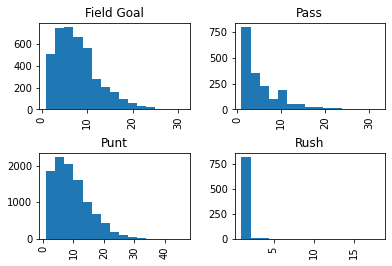

In [17]:
# Histogram of togo yards by Play Type.

df_hist = df[df['PlayTypeSimple'] != "Other"].query("Down == 4")
plot = df_hist['ToGo'].hist(by = df_hist['PlayTypeSimple'], bins = 15)


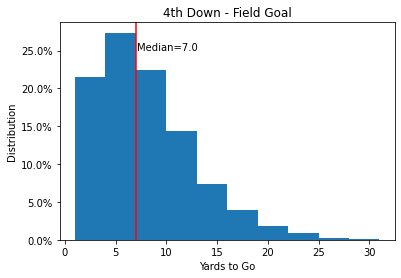

In [18]:
# Plot histogram of yards to go for field goals.

df_hist_fg = df[df['PlayTypeSimple'] == "Field Goal"].query("Down == 4")["ToGo"]

plt.hist(df_hist_fg, weights=np.ones(len(df_hist_fg)) / len(df_hist_fg))

plt.gca().yaxis.set_major_formatter(PercentFormatter(1))

plt.title("4th Down - Field Goal")
plt.xlabel("Yards to Go")
plt.ylabel("Distribution")

plt.axvline(df_hist_fg.median(), color = "red")
plt.text(df_hist_fg.median()+.1,.25,'Median='+ str(df_hist_fg.median()),rotation=0)

images_dir = '/content/gdrive/MyDrive/nfl_plots'
plt.savefig(f"{images_dir}/4th_fg.png")

plt.show()

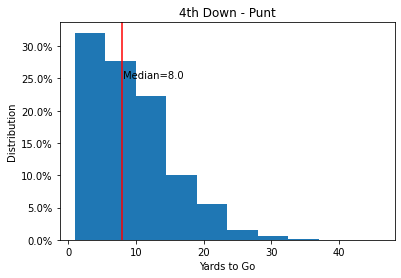

In [19]:
# Plot histogram of yards to go for punts.

df_hist_punt = df[df['PlayTypeSimple'] == "Punt"].query("Down == 4")["ToGo"]

plt.hist(df_hist_punt, weights=np.ones(len(df_hist_punt)) / len(df_hist_punt))

plt.gca().yaxis.set_major_formatter(PercentFormatter(1))

plt.title("4th Down - Punt")
plt.xlabel("Yards to Go")
plt.ylabel("Distribution")

plt.axvline(df_hist_punt.median(), color = "red")
plt.text(df_hist_punt.median()+.1,.25,'Median='+ str(df_hist_punt.median()),rotation=0)

images_dir = '/content/gdrive/MyDrive/nfl_plots'
plt.savefig(f"{images_dir}/4th_punt.png")

plt.show()

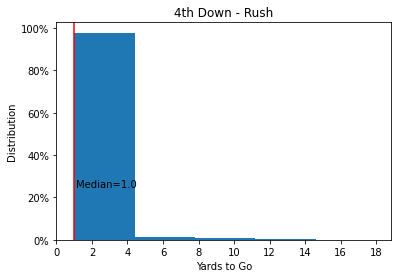

In [20]:
# Plot histogram of yards to go for rushes.

df_hist_rush = df[df['PlayTypeSimple'] == "Rush"].query("Down == 4")["ToGo"]

plt.hist(df_hist_rush, weights=np.ones(len(df_hist_rush)) / len(df_hist_rush), bins = 5)

plt.gca().yaxis.set_major_formatter(PercentFormatter(1))

plt.title("4th Down - Rush")
plt.xlabel("Yards to Go")
plt.ylabel("Distribution")
plt.xticks(range(0, 20, 2))


plt.axvline(df_hist_rush.median(), color = "red")
plt.text(df_hist_rush.median()+.1,.25,'Median='+ str(df_hist_rush.median()),rotation=0)

images_dir = '/content/gdrive/MyDrive/nfl_plots'
plt.savefig(f"{images_dir}/4th_rush.png")

plt.show()

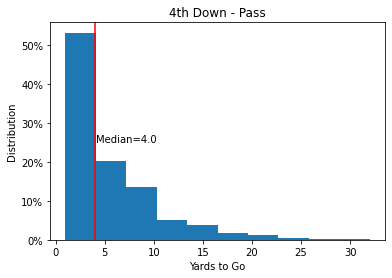

In [21]:
# Plot histogram of yards to go for pass plays.

df_hist_pass = df[df['PlayTypeSimple'] == "Pass"].query("Down == 4")["ToGo"]

plt.hist(df_hist_pass, weights=np.ones(len(df_hist_pass)) / len(df_hist_pass))

plt.gca().yaxis.set_major_formatter(PercentFormatter(1))

plt.title("4th Down - Pass")
plt.xlabel("Yards to Go")
plt.ylabel("Distribution")


plt.axvline(df_hist_pass.median(), color = "red")
plt.text(df_hist_pass.median()+.1,.25,'Median='+ str(df_hist_pass.median()),rotation=0)

images_dir = '/content/gdrive/MyDrive/nfl_plots'
plt.savefig(f"{images_dir}/4th_pass.png")

plt.show()

In [22]:
# Average yards to go by Season Year.

df.query("Down == 4").groupby("SeasonYear").agg({"ToGo":"mean"})

,ToGo
SeasonYear,
2017,7.892540
2018,8.000797
2019,8.131682
2020,7.467857
2021,7.704734


In [23]:
# 4th down conversion rate.

df["grouped_togo"] = np.where(df["ToGo"] > 10, 11, df["ToGo"])

df.query("Down == 4 & (PlayTypeSimple == 'Pass' | PlayTypeSimple == 'Rush')").groupby(["PlayTypeSimple", "grouped_togo"]).agg({"SeriesFirstDown":"mean", "PlayId": "count"})

SeriesFirstDown  PlayId
PlayTypeSimple grouped_togo                         
Pass           1                    0.541667     312
               2                    0.546429     280
               3                    0.444444     207
               4                    0.410000     200
               5                    0.411765     153
               6                    0.472441     127
               7                    0.440000     100
               8                    0.366667      60
               9                    0.209302      43
               10                   0.266667     150
               11                   0.251012     247
Rush           1                    0.662667     750
               2                    0.514706      68
               3                    0.428571       7
               4                    0.250000       8
               5                    0.250000       4
               6                    0.000000       3
               7                    0.333333       3
               8                    0.000000       1
               9                    0.000000       2
               10                   0.333333       3
               11                   0.000000       3

## Bayesian Modeling

### Prep data for analysis.

In [25]:
# Only extract the data we want.
df_modeling = df[(df["IsRush"] == 1) | (df["IsPass"] == 1)]
df_modeling = df_modeling[df_modeling["IsNoPlay"] == 0][["PlayId", "SeriesFirstDown", "ToGo", "IsRush", "IsPass", "YardLine"]]
df_modeling["RedZoneInd"] = np.where(df_modeling["YardLine"] <= 20, 1, 0)
df_modeling["ToGoTruncate"] = df_modeling["ToGo"]-1

# Set predictor and covariates.
y = df_modeling["SeriesFirstDown"]
x = df_modeling[["ToGo", "IsRush", "IsPass", "YardLine"]]

x1 = x["ToGo"]
x2 = x["IsPass"]
x3 = x["YardLine"]

# Set random seed.
random.seed(2)

# 70/30 split for validation.
y_t, y_v, x_t, x_v = train_test_split(y, x, test_size=0.30, shuffle=False)

# Store each field in separate arrays.
x1_t, x1_v, x2_t, x2_v, x3_t, x3_v, y1_t, y1_v = train_test_split(x1, x2, x3, y, test_size=0.30, shuffle=False)

# Split at dataframe level.
df_t, df_v = train_test_split(df_modeling, test_size=0.30, shuffle=False)



In [26]:
az.style.use("arviz-darkgrid")
SEED = 7355608

In [27]:
# Let's try the model with Bambi.

model_4th = bmb.Model("SeriesFirstDown ~ ToGo*IsPass + RedZoneInd", df_t, family="bernoulli")
model_4th_fitted = model_4th.fit(draws=2000, target_accept=0.85, random_seed=SEED)

Modeling the probability that SeriesFirstDown==1
WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [Intercept, RedZoneInd, ToGo:IsPass, IsPass, ToGo]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 1095 seconds.


In [29]:
model_4th

Formula: SeriesFirstDown ~ ToGo*IsPass + RedZoneInd
Family name: Bernoulli
Link: logit
Observations: 97552
Priors:
  Common-level effects
    Intercept ~ Normal(mu: 0, sigma: 7.0951)
    ToGo ~ Normal(mu: 0.0, sigma: 0.6259)
    IsPass ~ Normal(mu: 0.0, sigma: 5.0616)
    ToGo:IsPass ~ Normal(mu: 0.0, sigma: 0.4652)
    RedZoneInd ~ Normal(mu: 0.0, sigma: 8.1842)


------
* To see a plot of the priors call the .plot_priors() method.
* To see a summary or plot of the posterior pass the object returned by .fit() to az.summary() or az.plot_trace()

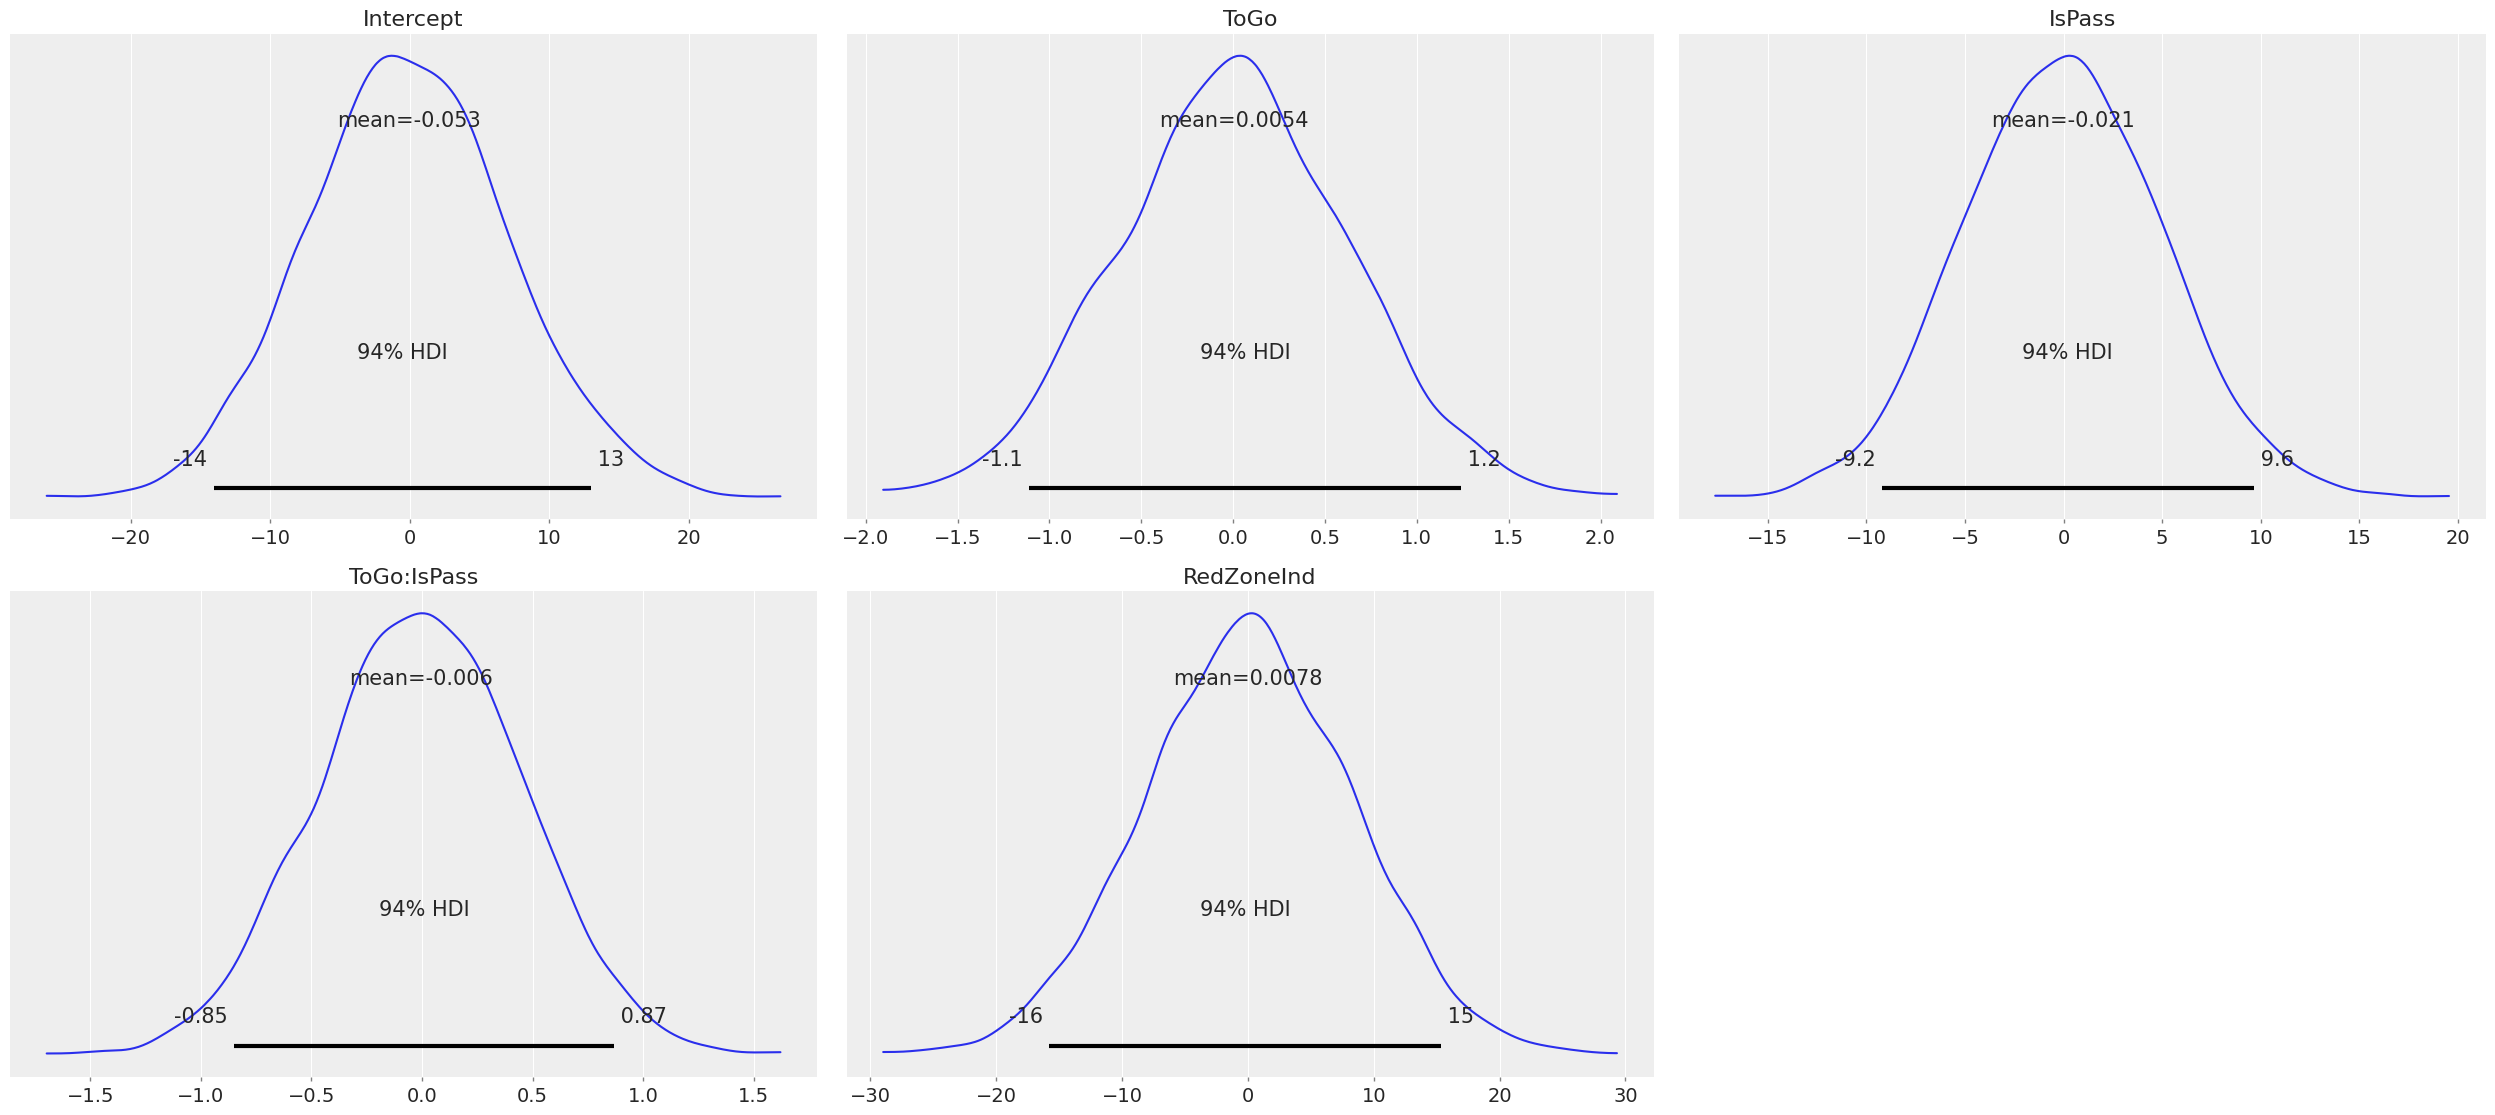

In [30]:
model_4th.plot_priors();

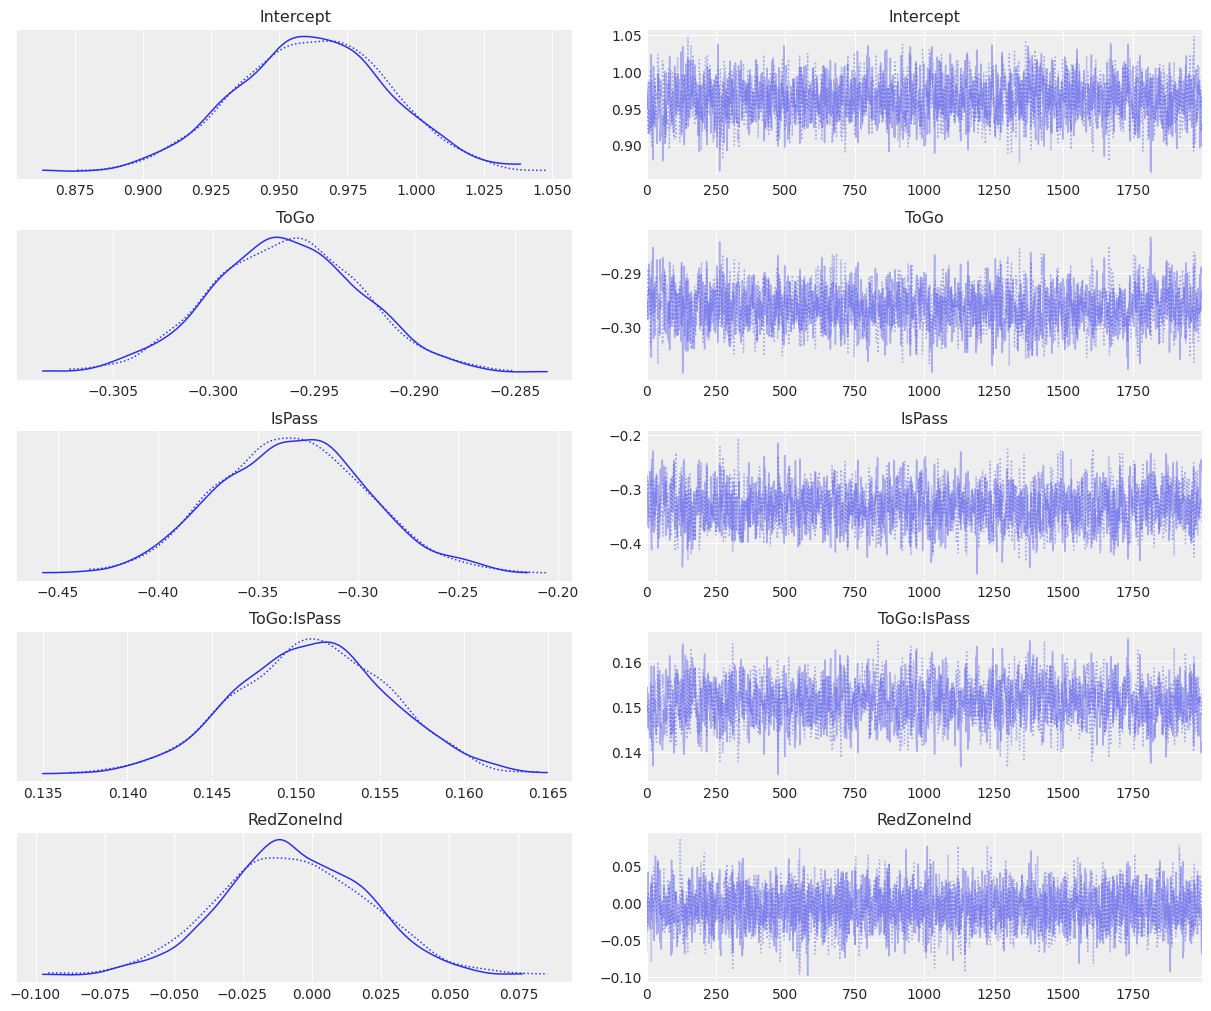

In [31]:
az.plot_trace(model_4th_fitted, compact=True);

In [32]:
az.summary(model_4th_fitted)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,0.962,0.028,0.908,1.012,0.001,0.000,1858.0,2265.0,1.0
ToGo,-0.296,0.004,-0.304,-0.290,0.000,0.000,1741.0,2037.0,1.0
IsPass,-0.333,0.037,-0.404,-0.265,0.001,0.001,1615.0,2246.0,1.0
ToGo:IsPass,0.151,0.005,0.143,0.160,0.000,0.000,1465.0,1818.0,1.0
RedZoneInd,-0.007,0.026,-0.057,0.041,0.000,0.000,3058.0,2515.0,1.0


In [33]:
az.summary(model_4th_fitted)["mean"]

Intercept      0.962
ToGo          -0.296
IsPass        -0.333
ToGo:IsPass    0.151
RedZoneInd    -0.007
Name: mean, dtype: float64

## Model Evaluation

In [34]:
model_4th_fitted

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

In [35]:
import arviz as az
import bambi as bmb
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import numpy as np
import pandas as pd
import seaborn as sns
import xarray as xr
import warnings

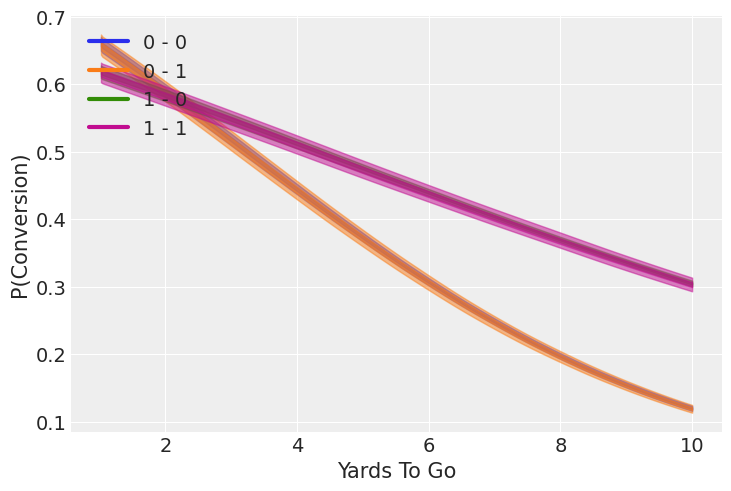

In [36]:

ToGo = list(range(1,11,1))

fig, ax = plt.subplots()
handles = []
i = 0

for IsPass in [0, 1]:
    for RedZoneInd in [0,1]:
        color = f"C{i}"
        label = f"{IsPass} - {RedZoneInd}"
        handles.append(mlines.Line2D([], [], color=color, label=label, lw=3))

        new_data = pd.DataFrame({
            "IsPass": [IsPass] * len(ToGo),
            "RedZoneInd": [RedZoneInd] * len(ToGo),
            "ToGo": ToGo
        })
        new_idata = model_4th.predict(model_4th_fitted, data=new_data, inplace=False)
        mean = new_idata.posterior["SeriesFirstDown_mean"].values

        az.plot_hdi(ToGo, mean, ax=ax, color=color)
        az.plot_hdi(ToGo, mean, ax=ax, color=color, hdi_prob=0.5)
        i += 1

ax.set_xlabel("Yards To Go")
ax.set_ylabel("P(Conversion)")
ax.legend(handles=handles, loc="upper left");

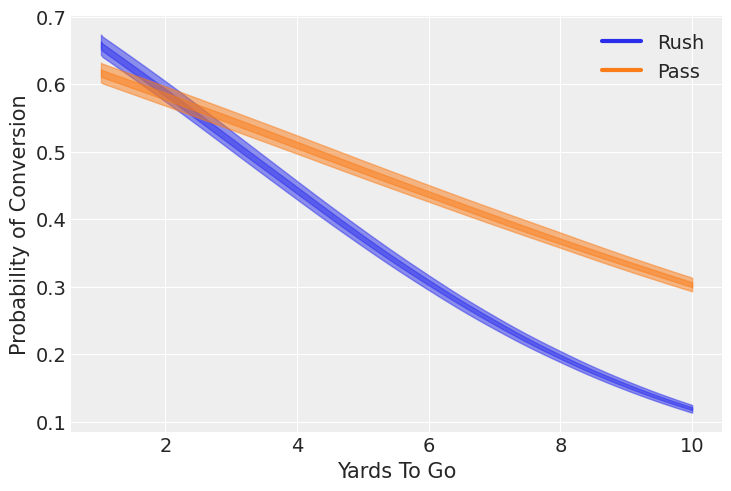

In [37]:

ToGo = list(range(1,11,1))

fig, ax = plt.subplots()
handles = []
i = 0

for IsPass in [0, 1]:
      color = f"C{i}"
      if IsPass == True:
        value = "Pass"
      else:
        value = "Rush"

      label = value
      handles.append(mlines.Line2D([], [], color=color, label=label, lw=3))

      new_data = pd.DataFrame({
          "IsPass": [IsPass] * len(ToGo),
          "RedZoneInd": [RedZoneInd] * len(ToGo),
          "ToGo": ToGo
      })
      new_idata = model_4th.predict(model_4th_fitted, data=new_data, inplace=False)
      mean = new_idata.posterior["SeriesFirstDown_mean"].values

      az.plot_hdi(ToGo, mean, ax=ax, color=color)
      az.plot_hdi(ToGo, mean, ax=ax, color=color, hdi_prob=0.5)
      i += 1

ax.set_xlabel("Yards To Go")
ax.set_ylabel("Probability of Conversion")
ax.legend(handles=handles, loc="upper right");